# 0. Load dependencies

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import h5py
import time
import random
import joblib
import datetime
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from shutil import copy
from pathlib import Path

from tensorflow import keras 
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Lambda
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add, Subtract, Multiply
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, SeparableConv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import Utility.ReadH5 as ReadH5
from Utility.log import logger
from Utility.loss import spectral_loss, combined_loss, hallucination_loss
from DataLoader.data_loader_blind import DataLoader
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# 1. Generate training data

## Load the hyperspectral data

Load and plot: hyperspectral microscopy image of CsPbBr3 nanoplatelet film.

Expect output: SI Figure 6a.

Time cost: 1-3 min

The image has a size of 1392 x 1040 x 66 pixels.


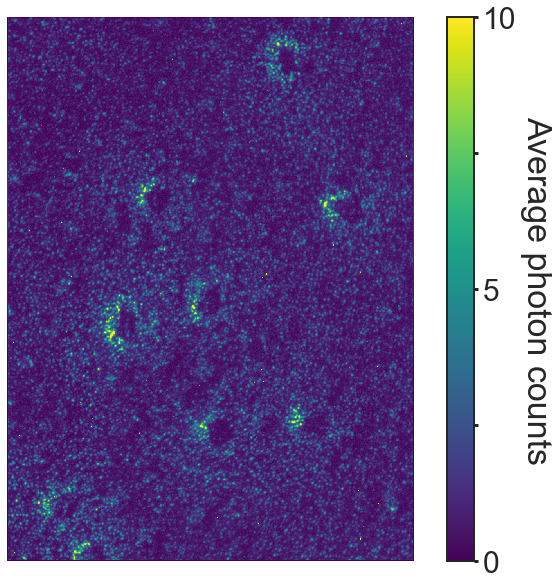

In [2]:
# Load data
file = r'CsPbBr3'
script_dir = os.path.dirname(os.path.realpath('__file__'))
path = Path(script_dir)
file_name = file + '.h5'
file_dir = os.path.join(str(path), 'Data', file_name)
with h5py.File(file_dir, 'r') as f:
    image = f['Cube']['Images'][()]
img = image.astype(np.float32)
img = np.swapaxes(np.swapaxes(img, -1, 0),0,1)
print('The image has a size of {} x {} x {} pixels.'.format(img.shape[0],img.shape[1],img.shape[2]))

# Plot PL intensity map
plt.style.use('seaborn-white')
matplotlib.rcParams['axes.linewidth'] = 2
font = {'size': 34}
matplotlib.rc('font', **font)
matplotlib.rcParams['xtick.major.pad']='8'
matplotlib.rcParams['ytick.major.pad']='8'
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

fig, ax = plt.subplots(figsize = (12,10))
mat = ax.matshow(np.mean(img,axis=2)/2**16*30000, cmap='viridis', vmin=0, vmax=10)  # Calculating effective photons from CCD readings (Supplementary Note 7)
cbar = fig.colorbar(mat)
cbar.ax.set_ylabel('Average photon counts',labelpad=35, rotation=-90)
cbar.ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=3, integer=True, steps=[1, 2, 5, 10]))
cbar.ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='y', direction='out',length=4,width=3,pad=5,labelsize=30)
cbar.ax.tick_params(axis='y',which='minor',direction='out',length=4,width=3,pad=5,labelsize=30)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

## Prepare training data

Preparing training data for learning by adding noise to the already noisy datacube.

We will plot a small section of the PL map corresponding to a region demonstrated in the main text (Figure 2a, 480 nm) to show how the amout of noise in image affect visual preception.

Expected output: a serie of images for training with different noise levels (sigma = 0, 5, 10, 20 or 50). 

Time cost: 5 min

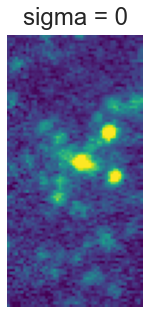

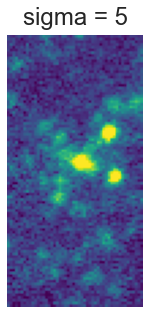

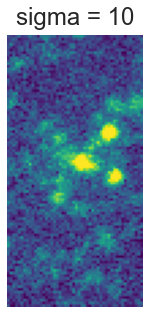

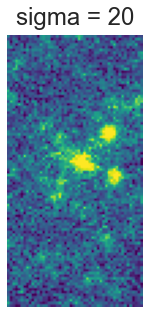

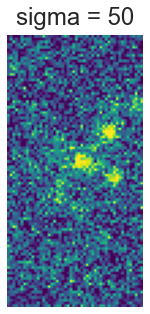

In [3]:
# normalize the image to a data range from -1 to 1 for training, and cut the high intensity noise from cosmic ray in datacube
img_norm,_,_ = ReadH5.normalization(img, dynamic=0.9999) 

# adding noise to the data
noise_list = [0, 5, 10, 20, 50]

for noise_rgb in noise_list:
    
    noisy_img = np.zeros(img.shape)
    pkl_data = {}
    noise_std = noise_rgb/255*2
    noisy_img = img_norm + np.random.normal(0, noise_std, img.shape)
    noisy_img = np.clip(noisy_img, -1, 1)
    
    if noise_rgb == 0:
        pkl_data = {'train':{'HR': img_norm[:, :, :],},'valid':{'LR': None, 'HR': None,},'test':{'LR': None, 'HR': None,}}
    else:
        pkl_data = {
            'train':{'LR': noisy_img[:, :, :],},'valid':{'LR': None,'HR': None,},'test':{'LR': None,'HR': None,}}
    
    with open(os.path.join(str(path), 'Data', 'Train', '{}_{}.joblib'.format(file, noise_rgb)), 'wb') as handle:
        joblib.dump(pkl_data, handle)
        
    # plot images
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(ReadH5.normalization(noisy_img[1000:1100,468:518,30], dynamic = 0.99)[0],cmap='viridis',)
    ax.set_frame_on(False)
    ax.set(xticklabels=[])
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlabel('sigma = {}'.format(noise_rgb), labelpad=10, fontsize=24)
    ax.xaxis.set_label_position('top')

# clean up memory
del img
del img_norm
del noisy_img
del pkl_data

# 2. Train the model

## Load the machine learning algorithm and the prepared dataset

Expect output: "Loading completed!" message.

Time cost: 3-5 min

In [4]:
class PANet():
    def __init__(self, experiment_name, file_name, dataset_name='standard_1'):
        # Input shape
        self.imgsize = 64
        self.channels = 32
        self.lr_height = self.imgsize  # Low resolution height
        self.lr_width = self.imgsize  # Low resolution width
        self.lr_shape = (None, None, self.channels)
        self.hr_height = self.imgsize  # High resolution height
        self.hr_width = self.imgsize  # High resolution width
        self.hr_shape = (None, None, self.channels)
        self.sigma_shape = (None, None, 1)
        self.noise_list = [5, 10, 20, 50]
        
        os.makedirs('Model/saved_model/%s' % experiment_name, exist_ok=True)
        
        self.file_name = file_name
        self.experiment_name = experiment_name  # The experiment name

        # Number of residual blocks in the generator
        self.n_residual_blocks = 16
        
        self.default_lr = 0.0002
        optimizer = Adam(self.default_lr, 0.5)

        # Configure data loader
        self.dataset_name = dataset_name
        self.data_loader = DataLoader(self.file_name, self.dataset_name,
                                      img_res=(self.hr_height, self.hr_width), channel=self.channels)
        
        # Calculate output shape of D (PatchGAN)
        patch = int(self.hr_height / 2 ** 4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32

        # Build the generator
        self.detector = self.build_detector()
        self.detector.compile(loss='mse',
                           optimizer=optimizer,
                           metrics=[])
        
        self.generator = self.build_generator()
        img_lr = Input(shape=self.lr_shape)
        sigma = self.detector(img_lr)
        gen_hr = self.generator([img_lr, sigma])

        def hallucination_loss(y_true, y_pred):
            y_true = K.cast(y_true, y_pred.dtype)
            den = K.square(y_true + 1) + 0.001
            weights = tf.divide(0.001, den)-0.95
            weights = K.relu(weights)+1
            normal_mse = K.square(y_pred - y_true)
            weighted_loss = normal_mse * weights
            mean_weighted_loss = K.mean(weighted_loss, axis=-1)

            return mean_weighted_loss

        def spectral_loss(y_true, y_pred):
            y_true = K.cast(y_true, y_pred.dtype)

            # Calculate grad
            grad_HR = y_true[:, :, :, :-1] - y_true[:, :, :, 1:]
            grad_SR = y_pred[:, :, :, :-1] - y_pred[:, :, :, 1:]

            grad_diff = grad_HR - grad_SR
            grad_diff_1 = grad_diff[:, :, :, :-1]
            grad_diff_2 = grad_diff[:, :, :, 1:]

            spec_loss = K.mean(0.5 * K.square(grad_diff_1) +
                               0.5 * K.square(grad_diff_2), axis=-1)

            return spec_loss

        def combined_loss(y_true, y_pred, A=0.1, B=0):
            y_true = K.cast(y_true, y_pred.dtype)

            spec_loss = spectral_loss(y_true, y_pred)
            normal_mse = K.mean(K.square(y_pred - y_true), axis=-1)
            hallu_loss = hallucination_loss(y_true, y_pred)

            # change params here
            merged_loss = normal_mse + A*spec_loss + B*hallu_loss

            return merged_loss

        # Compile combined model
        self.combined = Model([img_lr], [gen_hr, sigma])
        self.combined.compile(loss=[combined_loss, 'mse'],
                              metrics=['mse',],
                              loss_weights=[1,1],
                              optimizer=optimizer)
        
    def calculate_learning_rate(self, epoch_x_batchsize, c=0.02):
        if epoch_x_batchsize < 1000:
            return self.default_lr
        elif epoch_x_batchsize > 50000:
            return self.default_lr * np.exp(0.01 * (100 - 5000) * c)
        else:
            return self.default_lr * np.exp(0.01 * (100 - epoch_x_batchsize/10) * c)
        
    def build_generator(self):

        def residual_block(layer_input, filters):
            """Residual block described in paper"""
            d = Conv2D(filters, kernel_size=3, strides=1,
                       padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        def deconv2d(layer_input):
            """Layers used during upsampling"""
            u = Conv2D(self.gf*4, kernel_size=3, strides=1,
                       padding='same')(layer_input)
            u = Activation('relu')(u)
            return u
        
        def pad():
            def func(x):
                x = K.ones_like(x)
                x = x[:, :, :, -1:]
                return x*0.01
            return Lambda(func, output_shape=(None, None, 1))
        
        # noisy image input
        img_lr = Input(shape=(None, None, self.channels))
        sigma = Input(shape=(None,))
        sigma_reshape = Reshape((1,1,1))(sigma)

        padding = pad()(img_lr)
        padding = Multiply()([padding, sigma_reshape])
        padded_lr = Concatenate(axis=-1)([img_lr, padding])
        
        # Pre-residual block
        c1 = Conv2D(self.gf*4, kernel_size=3,
                    strides=1, padding='same')(padded_lr)
        c2 = LeakyReLU(alpha=0.2)(c1)
        c2 = Conv2D(self.gf*2, kernel_size=3, strides=1, padding='same')(c2)
        c3 = LeakyReLU(alpha=0.2)(c2)
        c3 = BatchNormalization(momentum=0.8)(c3)
        c3 = Conv2D(self.gf, kernel_size=3, strides=1, padding='same')(c3)
        c4 = LeakyReLU(alpha=0.2)(c3)
        c4 = BatchNormalization(momentum=0.8)(c4)
        
        # Propogate through residual blocks
        r = residual_block(c4, self.gf)
        for _ in range(self.n_residual_blocks - 3):
            r = residual_block(r, self.gf)

        # Post-residual block
        c5 = Conv2D(self.gf, kernel_size=3, strides=1, padding='same')(r)
        c5 = LeakyReLU(alpha=0.2)(c5)
        c5 = BatchNormalization(momentum=0.8)(c5)
        c5 = Add()([c5, c3])
        c6 = Conv2D(self.gf*2, kernel_size=3, strides=1, padding='same')(c5)
        c6 = LeakyReLU(alpha=0.2)(c6)
        c6 = BatchNormalization(momentum=0.8)(c6)
        c6 = Add()([c6, c2])
        c7 = Conv2D(self.gf*4, kernel_size=3, strides=1, padding='same')(c6)
        c7 = BatchNormalization(momentum=0.8)(c7)
        c7 = Add()([c7, c1])

        # Upsampling
        u1 = deconv2d(c7)
        u2 = deconv2d(u1)

        # Generate high resolution output
        gen_hr = Conv2D(self.channels, kernel_size=3, strides=1,
                        padding='same', activation='tanh')(u2)

        return Model([img_lr, sigma], gen_hr)
    
    def build_detector(self):
        
        def residual_block(layer_input, filters):
            """Residual block described in paper"""
            d = Conv2D(filters, kernel_size=3, strides=1,
                       padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d
        
        def crop(size):
            def func(x):
                return x[:, :size, :size, :]
            return Lambda(func, output_shape=(size,size,self.gf))

        # noisy image input, input x & y size >= 64
        img_lr = Input(shape=(None, None, self.channels))

        # Pre block
        c1 = Conv2D(self.gf, kernel_size=3,
                    strides=1, padding='same')(img_lr)
        c2 = LeakyReLU(alpha=0.2)(c1)
        
        r = residual_block(c2, self.gf)
        for _ in range(5):
            r = residual_block(r, self.gf)
            
        c3 = Conv2D(self.gf, kernel_size=3, strides=1, padding='same')(r)
        c3 = Add()([c3, c1])
        # Generate Estimation for Sigma for 64*64 image size 
        n1 = crop(64)(c3)
        n1.set_shape(shape=(None, 64, 64, self.gf))
        n2 = Conv2D(self.gf, kernel_size=3, strides=2)(n1)
        n3 = Conv2D(self.gf*2, kernel_size=3, strides=2)(n2)
        n4 = Conv2D(self.gf*4, kernel_size=3, strides=2)(n3)
        n5 = Conv2D(self.gf*4, kernel_size=3, strides=2)(n4)
        n6 = Dense(self.gf*8)(n5)
        n7 = LeakyReLU(alpha=0.2)(n6)
        n8 = Flatten()(n7)
        sigma = Dense(1)(n8)
        
        return Model(img_lr, sigma)
    
    def train(self, epochs, batch_size=1, save_interval=100):

        start_time = datetime.datetime.now()
            
        gen_model_path = r'Model/DCMall_pretrained.h5'
        self.combined.load_weights(gen_model_path)

        for epoch in range(epochs):
            current_epoch = epoch + 1
            
            sigma_index = np.array([0] * batch_size)
            sigma = [0] * batch_size

            for i in range(batch_size):
                sigma_index[i] = random.randint(0,len(self.noise_list)-1)
                sigma[i] = self.noise_list[sigma_index[i]]

            imgs_hr, imgs_lr = self.data_loader.load_data(batch_size,sigma=sigma)
            
            # Train the generators only
            current_learning_rate = self.calculate_learning_rate(current_epoch*batch_size)
            K.set_value(self.combined.optimizer.lr, current_learning_rate)
            
            g_loss = self.combined.train_on_batch(
                imgs_lr, [imgs_hr, np.array(sigma)])
            # NOTE: g_loss[0] is combined model loss

            elapsed_time = datetime.datetime.now() - start_time

            # Plot the progress
            loss_str = ''
            loss_str += 'combined-> '
            for i in range(len(g_loss)):
                loss_str += '{}:{} ||'.format(
                    self.combined.metrics_names[i], g_loss[i])
            
            logger.info("%d time: %s  %s" %
                        (current_epoch, elapsed_time, loss_str))
            
            # Save model at save_interval
            if current_epoch % save_interval == 0:
                self.combined.save(
                    'Model/saved_model/{}/'.format(self.experiment_name) + 'gen_model%d.h5' % current_epoch)
                
        logger.info('Training completed.')
        
net = PANet(experiment_name='CsPbBr3', file_name='CsPbBr3', dataset_name='standard_1')
print("Loading completed!")

dict_keys([0, 5, 10, 20, 50]) loaded
Loading completed!


In [5]:
net.generator.summary()
net.detector.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, None, 1 0           input_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 1, 1)      0           input_3[0][0]                    
____________________________________________________________________________________________

## (Optional) Train the algorithm

We also provide an already-trained model for quick data analysis. To do so, skip this section or stop the following code at any time and run later sections.

Expect output: training step reaches 15000 and stops. Combined loss is expected to decrease over time until reaching its local minimum.

Time cost: 1 hours (Nvidia A100), 2.5 hours (Nvidia GeForce RTX 3080) or 85 hours (CPU)

In [ ]:
net.train(epochs=20000, batch_size=32, save_interval=1000)

2023-10-07 12:45:16,409 - Utility.log - INFO - 1 time: 0:00:16.315807  combined-> loss:58.714107513427734 ||model_1_loss:0.012700353749096394 ||model_loss:58.70140838623047 ||model_1_mse:0.01194838434457779 ||model_mse:58.70140838623047 ||
2023-10-07 12:45:17,069 - Utility.log - INFO - 2 time: 0:00:16.975223  combined-> loss:16.874319076538086 ||model_1_loss:0.010981992818415165 ||model_loss:16.86333656311035 ||model_1_mse:0.010177405551075935 ||model_mse:16.86333656311035 ||
2023-10-07 12:45:17,703 - Utility.log - INFO - 3 time: 0:00:17.611506  combined-> loss:20.92765998840332 ||model_1_loss:0.011416636407375336 ||model_loss:20.916242599487305 ||model_1_mse:0.010600737296044827 ||model_mse:20.916242599487305 ||
2023-10-07 12:45:18,340 - Utility.log - INFO - 4 time: 0:00:18.246749  combined-> loss:6.377126216888428 ||model_1_loss:0.008917250670492649 ||model_loss:6.368208885192871 ||model_1_mse:0.008119400590658188 ||model_mse:6.368208885192871 ||
2023-10-07 12:45:18,954 - Utility.log

2023-10-07 12:45:38,005 - Utility.log - INFO - 35 time: 0:00:37.913231  combined-> loss:1.5973756313323975 ||model_1_loss:0.00748093705624342 ||model_loss:1.5898946523666382 ||model_1_mse:0.006640369072556496 ||model_mse:1.5898946523666382 ||
2023-10-07 12:45:38,617 - Utility.log - INFO - 36 time: 0:00:38.523474  combined-> loss:3.5925405025482178 ||model_1_loss:0.006853706669062376 ||model_loss:3.585686683654785 ||model_1_mse:0.006055308040231466 ||model_mse:3.585686683654785 ||
2023-10-07 12:45:39,224 - Utility.log - INFO - 37 time: 0:00:39.133270  combined-> loss:2.198593854904175 ||model_1_loss:0.009163177572190762 ||model_loss:2.1894307136535645 ||model_1_mse:0.008290369063615799 ||model_mse:2.1894307136535645 ||
2023-10-07 12:45:39,841 - Utility.log - INFO - 38 time: 0:00:39.748747  combined-> loss:1.048019528388977 ||model_1_loss:0.008887866511940956 ||model_loss:1.0391316413879395 ||model_1_mse:0.008025762625038624 ||model_mse:1.0391316413879395 ||
2023-10-07 12:45:40,480 - Uti

2023-10-07 12:45:59,761 - Utility.log - INFO - 69 time: 0:00:59.669312  combined-> loss:1.3433488607406616 ||model_1_loss:0.00600830651819706 ||model_loss:1.3373405933380127 ||model_1_mse:0.005258738063275814 ||model_mse:1.3373405933380127 ||
2023-10-07 12:46:00,375 - Utility.log - INFO - 70 time: 0:01:00.282945  combined-> loss:1.9039332866668701 ||model_1_loss:0.006377968937158585 ||model_loss:1.8975553512573242 ||model_1_mse:0.0055839791893959045 ||model_mse:1.8975553512573242 ||
2023-10-07 12:46:01,001 - Utility.log - INFO - 71 time: 0:01:00.908617  combined-> loss:4.803183078765869 ||model_1_loss:0.0064863171428442 ||model_loss:4.796696662902832 ||model_1_mse:0.005673813633620739 ||model_mse:4.796696662902832 ||
2023-10-07 12:46:01,636 - Utility.log - INFO - 72 time: 0:01:01.543152  combined-> loss:3.3818278312683105 ||model_1_loss:0.006540725938975811 ||model_loss:3.3752870559692383 ||model_1_mse:0.005761695094406605 ||model_mse:3.3752870559692383 ||
2023-10-07 12:46:02,288 - Uti

2023-10-07 12:46:22,360 - Utility.log - INFO - 103 time: 0:01:22.265291  combined-> loss:1.5947673320770264 ||model_1_loss:0.006474614609032869 ||model_loss:1.5882927179336548 ||model_1_mse:0.005664908327162266 ||model_mse:1.5882927179336548 ||
2023-10-07 12:46:23,022 - Utility.log - INFO - 104 time: 0:01:22.928652  combined-> loss:0.9589101076126099 ||model_1_loss:0.006319384090602398 ||model_loss:0.9525907039642334 ||model_1_mse:0.005538522731512785 ||model_mse:0.9525907039642334 ||
2023-10-07 12:46:23,638 - Utility.log - INFO - 105 time: 0:01:23.546230  combined-> loss:0.595685601234436 ||model_1_loss:0.005967993289232254 ||model_loss:0.5897176265716553 ||model_1_mse:0.005226419307291508 ||model_mse:0.5897176265716553 ||
2023-10-07 12:46:24,266 - Utility.log - INFO - 106 time: 0:01:24.172616  combined-> loss:1.5240917205810547 ||model_1_loss:0.005915127694606781 ||model_loss:1.518176555633545 ||model_1_mse:0.0051704589277505875 ||model_mse:1.518176555633545 ||
2023-10-07 12:46:24,88

2023-10-07 12:46:44,303 - Utility.log - INFO - 137 time: 0:01:44.209927  combined-> loss:0.678563117980957 ||model_1_loss:0.005910876207053661 ||model_loss:0.6726522445678711 ||model_1_mse:0.005167970433831215 ||model_mse:0.6726522445678711 ||
2023-10-07 12:46:44,962 - Utility.log - INFO - 138 time: 0:01:44.868999  combined-> loss:1.2190345525741577 ||model_1_loss:0.005950574297457933 ||model_loss:1.2130839824676514 ||model_1_mse:0.005212345160543919 ||model_mse:1.2130839824676514 ||
2023-10-07 12:46:45,630 - Utility.log - INFO - 139 time: 0:01:45.535253  combined-> loss:1.3732582330703735 ||model_1_loss:0.0061362795531749725 ||model_loss:1.367121934890747 ||model_1_mse:0.00538252480328083 ||model_mse:1.367121934890747 ||
2023-10-07 12:46:46,320 - Utility.log - INFO - 140 time: 0:01:46.225628  combined-> loss:0.8618313670158386 ||model_1_loss:0.006067103706300259 ||model_loss:0.8557642698287964 ||model_1_mse:0.005317870527505875 ||model_mse:0.8557642698287964 ||
2023-10-07 12:46:47,044

2023-10-07 12:47:06,238 - Utility.log - INFO - 171 time: 0:02:06.146026  combined-> loss:4.2715349197387695 ||model_1_loss:0.006345032714307308 ||model_loss:4.265190124511719 ||model_1_mse:0.005553052760660648 ||model_mse:4.265190124511719 ||
2023-10-07 12:47:06,852 - Utility.log - INFO - 172 time: 0:02:06.760668  combined-> loss:3.2259254455566406 ||model_1_loss:0.006670461036264896 ||model_loss:3.219254970550537 ||model_1_mse:0.005874580703675747 ||model_mse:3.219254970550537 ||
2023-10-07 12:47:07,497 - Utility.log - INFO - 173 time: 0:02:07.404430  combined-> loss:0.8592884540557861 ||model_1_loss:0.006662614643573761 ||model_loss:0.852625846862793 ||model_1_mse:0.005892139859497547 ||model_mse:0.852625846862793 ||
2023-10-07 12:47:08,096 - Utility.log - INFO - 174 time: 0:02:08.002420  combined-> loss:1.5236568450927734 ||model_1_loss:0.00560593418776989 ||model_loss:1.5180509090423584 ||model_1_mse:0.004902216140180826 ||model_mse:1.5180509090423584 ||
2023-10-07 12:47:08,741 - U

# 3. Process the raw image

## Load the trained model

To reproduce the paper results, the provided trained model can be loaded by running the following code.

Expect output: "Loading completed!" message.

Time cost: 1-3 min

In [12]:
# clear unused memories
del net.data_loader

# load model
load_model_path = r'Model/CsPbBr3_blind.h5'
net.combined.load_weights(load_model_path)
print("Loading completed!")

Loading completed!


... or load the current trained model from the previous step

In [6]:
load_model_path = r'Model/saved_model/CsPbBr3/gen_model10000.h5'
net.combined.load_weights(load_model_path)
print("Loading completed!")

Loading completed!


## Run denoising

Expect output: "Denoising completed!" message

Time cost: 3-5 min

In [13]:
# load raw data
file = r'CsPbBr3'
channel = 32
script_dir = os.path.dirname(os.path.realpath('__file__'))
path = Path(script_dir)
file_name = file + '.h5'
file_dir = os.path.join(str(path), 'Data', file_name)
with h5py.File(file_dir, 'r') as f:
    img = f['Cube']['Images'][()]
img_max = np.max(img)
img,img_max,img_min = ReadH5.normalization(np.expand_dims(np.swapaxes(np.swapaxes(img, -1, 0),0,1),0), dynamic=0.9999)
shape = img.shape
mid = int(shape[-1]/2)

division_factor = np.zeros((img.shape[-1]))
output_img = np.zeros(img.shape)
total_noise_level = np.zeros((max(1,img.shape[-1]-channel+1)))
start_time = time.time()

# denoising
for i in range(max(1,img.shape[-1]-channel+1)):
    division_factor[i:i+channel] += np.ones((channel))
    result,noise_level = net.combined.predict(img[:,:,:,i:i+channel]) 
    output_img[:,:,:,i:i+channel] += result
    total_noise_level[i] = noise_level

for i in range(shape[-1]):
    output_img[:,:,:,i] = output_img[:,:,:,i]/division_factor[i]
    
print('Denoising completed! Time cost {} s per frame.'.format((time.time() - start_time)/img.shape[-1]))
del img

Denoising completed! Time cost 0.6350601441932447 s per frame.


## Save the data

Expect output: a .h5 file containing denoised image. 

Time cost: <1 min

In [14]:
def write_H5(filename, data, wavelength_data=None, original_dir=None):
    if original_dir is not None:
        copy(original_dir, filename)
        hf = h5py.File(filename, 'r+')
        del hf['Cube']['Images']
        hf['Cube'].create_dataset('Images', data=data.astype(np.float32))
        hf.close()
    else:
        hf = h5py.File(filename, 'w')
        g1 = hf.create_group('Cube')
        g1.create_dataset('Images', data=data.astype(np.float16))
        if wavelength_data is not None:
            g1.create_dataset('Wavelength', data=wavelength_data)
        hf.close()
    return None

output_img = ReadH5.revert_normalization(np.swapaxes(np.swapaxes(output_img[0,:,:,:], 0, 1),-1,0), img_max, img_min)
output_name = 'Results/'+ file + '_denoised.h5'
write_H5(output_name,output_img,original_dir=file_dir)
print("Save successful at {}.".format(Path(output_name)))

Save successful at Results\CsPbBr3_denoised.h5.


# 4. Analyze the result

## Load the data

Time cost: 1 min

In [15]:
img_raw = ReadH5.load_H5(r'Data/CsPbBr3.h5')/2**16*30000
img_denoised = ReadH5.load_H5(r'Results/CsPbBr3_denoised.h5')/2**16*30000
wav = list(range(420, 552, 2))

## Reproducing Figure 2a

Expected output: Figure 2a (left), 2b (right), 470 nm

Time cost: 1 min

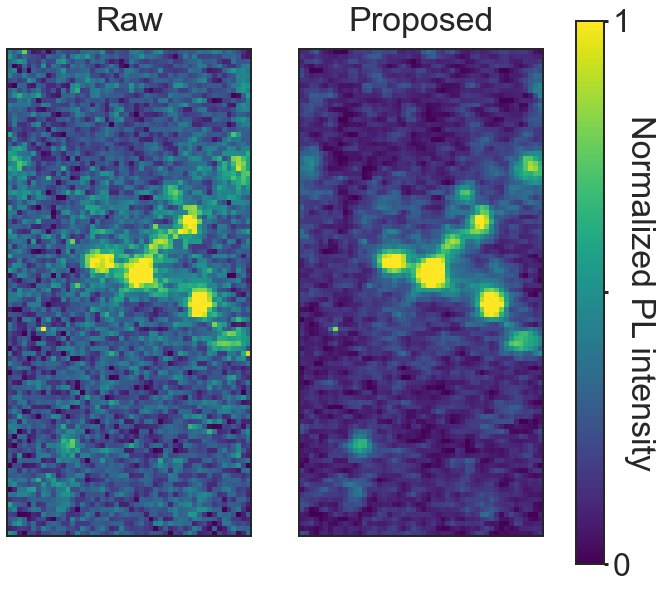

In [16]:
plt.style.use('seaborn-white')
matplotlib.rcParams['axes.linewidth'] = 2
font = {'size': 34}
matplotlib.rc('font', **font)
matplotlib.rcParams['xtick.major.pad']='8'
matplotlib.rcParams['ytick.major.pad']='8'
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, gridspec_kw=dict(width_ratios=[1, 1],hspace=0.075),figsize=(12, 10))
mat = ax0.matshow(ReadH5.normalization(img_raw[25,1000:1100,468:518], dynamic = 0.99, rang=[0,1])[0], cmap='viridis')
ax0.set(xticklabels=[])
ax0.axes.get_yaxis().set_visible(False)
ax0.set_xlabel('Raw', labelpad=10)
ax0.xaxis.set_label_position('top')
mat = ax1.matshow(ReadH5.normalization(img_denoised[25,1000:1100,468:518], dynamic = 0.99, rang=[0,1])[0], cmap='viridis')
ax1.set(xticklabels=[])
ax1.axes.get_yaxis().set_visible(False)
ax1.set_xlabel('Proposed', labelpad=10)
ax1.xaxis.set_label_position('top')
cbar = fig.colorbar(mat, ax=[ax0,ax1])
cbar.ax.tick_params(axis='y', direction='out',length=4,width=3,pad=5,labelsize=32)
cbar.ax.set_ylabel('Normalized PL intensity',labelpad=25, rotation=-90)
cbar.ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=3, integer=True, steps=[1, 2, 5, 10]))
cbar.ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='y',which='minor',direction='out',length=4,width=3,pad=5,labelsize=32)

## Reproducing SI Figure 6c

Expect output: SI Figure 6c

Time cost: 3-5 min

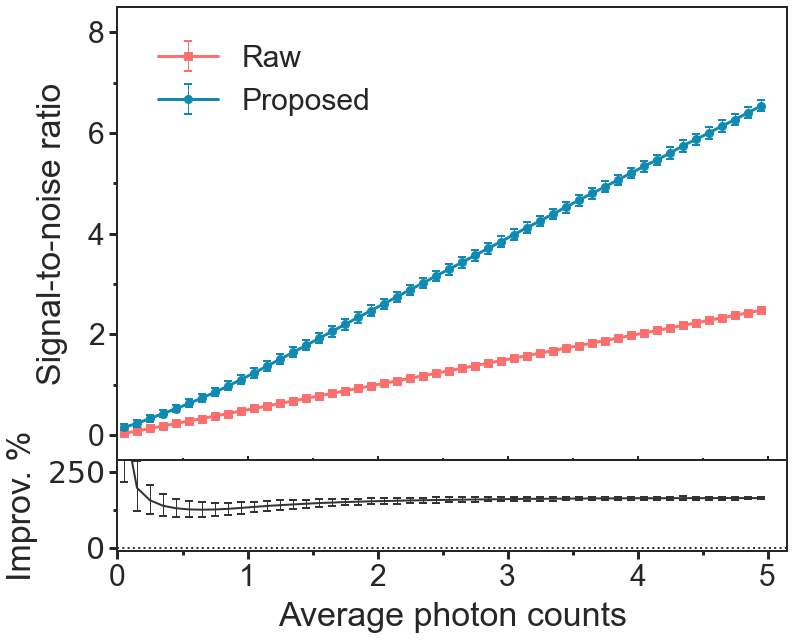

In [17]:
# SNR mapping statistics
import scipy
from scipy.stats import gaussian_kde, binned_statistic, binned_statistic_2d

def signaltonoise(a, std, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    return m/std

img_int = np.mean(img_raw,axis=0).flatten()
img_raw_snr = signaltonoise(img_raw,np.std(img_raw[:,101:109,710:718]),axis=(0)).flatten()
img_denoised_snr = signaltonoise(img_denoised,np.std(img_denoised[:,101:109,710:718]),axis=(0)).flatten()

# remove pixels of counts<=0
delete_list = []
for i, value in enumerate(img_raw_snr):
    if value <= 0:
        delete_list.append(i)
img_int = np.delete(img_int, delete_list)
img_raw_snr = np.delete(img_raw_snr, delete_list)
img_denoised_snr = np.delete(img_denoised_snr, delete_list)

int_range = [0,5]
int_bin = (int_range[1]-int_range[0])*10

raw_median, bin_edges, _ = binned_statistic(img_int, img_raw_snr, statistic='median', bins=int_bin, range=[int_range])
raw_25, _, _ = binned_statistic(img_int, img_raw_snr, statistic=lambda y: np.percentile(y, 25), bins=int_bin, range=[int_range])
raw_75, _, _ = binned_statistic(img_int, img_raw_snr, statistic=lambda y: np.percentile(y, 75), bins=int_bin, range=[int_range])
raw_count, _, _ = binned_statistic(img_int, img_raw_snr, statistic='count', bins=int_bin, range=[int_range])
de_median, _, _ = binned_statistic(img_int, img_denoised_snr, statistic='median', bins=int_bin, range=[int_range])
de_25, _, _ = binned_statistic(img_int, img_denoised_snr, statistic=lambda y: np.percentile(y, 25), bins=int_bin, range=[int_range])
de_75, _, _ = binned_statistic(img_int, img_denoised_snr, statistic=lambda y: np.percentile(y, 75), bins=int_bin, range=[int_range])

improv = np.array((img_denoised_snr/img_raw_snr-1)*100)

improv_median, _, _ = binned_statistic(img_int, improv, statistic=lambda y: np.median(y), bins=int_bin, range=[int_range])
improv_25, _, _ = binned_statistic(img_int, improv, statistic=lambda y: np.percentile(y, 25), bins=int_bin, range=[int_range])
improv_75, _, _ = binned_statistic(img_int, improv, statistic=lambda y: np.percentile(y, 75), bins=int_bin, range=[int_range])

# plot the analysis
plt.style.use('seaborn-white')
matplotlib.rcParams['axes.linewidth'] = 2
font = {'size': 34}
matplotlib.rc('font', **font)
matplotlib.rcParams['xtick.major.pad'] = '8'
matplotlib.rcParams['ytick.major.pad'] = '8'
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
labelsize=30

fig, (ax0, ax1) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[5, 1]),figsize=(12, 10))

ax0.errorbar(bin_edges[:-1]+0.05, raw_median, yerr=np.array([raw_median-raw_25,raw_75-raw_median]),
             linestyle='-', label='Raw', marker='s', elinewidth=1, capsize=4, capthick=2, color=matplotlib.colors.to_rgba('#fb6f6f')[:-1]+(1,), linewidth=3, markersize=8, zorder=1)
ax0.errorbar(bin_edges[:-1]+0.05, de_median, yerr=np.array([de_median-de_25,de_75-de_median]),
             linestyle='-', label='Proposed', marker='o', elinewidth=1, capsize=4, capthick=2, color=matplotlib.colors.to_rgba('#118ab2')[:-1]+(1,), linewidth=3, markersize=8, zorder=2)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(fontsize=30, loc='lower left', bbox_to_anchor=(0.02, 0.70))
ax0.set_xlim(int_range)
ax0.set_ylim([-0.5, 8.5])
ax0.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
ax0.set_ylabel('Signal-to-noise ratio', labelpad=20)
ax0.tick_params(axis='y', direction='out', length=8, width=3, pad=5, labelsize=labelsize)
ax0.tick_params(axis='x', direction='inout', length=8, width=2, pad=5, labelsize=labelsize)
ax0.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=6, integer=True, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=5, integer=False, steps=[2, 5]))
ax0.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='y', which='minor', direction='out', length=4, width=3, pad=5)
ax0.tick_params(axis='x', which='minor', direction='inout', length=4, width=2, pad=5)

ax1.errorbar(bin_edges[:-1]+0.05, improv_median, yerr=np.array([improv_median-improv_25,improv_75-improv_median]), 
         elinewidth=1, capsize=4, capthick=2, color=matplotlib.colors.to_rgba('#333333'), linewidth=2)
ax1.hlines(y=0, xmin=0, xmax=10, linestyles='dotted', linewidth=2, color=matplotlib.colors.to_rgba('#333333'))
ax1.yaxis.set_ticklabels([])
ax0.set_xlim([0,5.15])
ax1.set_ylim([-10, 290])
ax1.set_xlabel('Average photon counts', labelpad=10)
ax1.set_ylabel('Improv. %', labelpad=9)
ax1.tick_params(axis='both', direction='out', length=8, width=3, pad=5, labelsize=labelsize)
ax1.tick_params(axis='both', which='minor', direction='out', length=4, width=3, pad=5)
f = matplotlib.ticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%d' % x))
ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(g))
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=6, integer=True, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
plt.subplots_adjust(hspace=.0)